## Importing Required Libraries

In [162]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

from tensorflow.keras.applications import VGG19
import matplotlib.pyplot as plt
%matplotlib inline

In [163]:
from time import time
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt

import os
import cv2
import csv
import numpy as np
from time import time
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
import matplotlib.pyplot as plt
%matplotlib inline

from keras import Sequential, Model
from keras.applications import Xception
from keras.layers import Flatten, Dense, Softmax, GlobalAvgPool2D
from keras.preprocessing import image
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

## Assigning Path for Dataset

In [164]:
data_dir = '../input/gtsrb-german-traffic-sign'
train_path = '../input/gtsrb-german-traffic-sign/Train'
test_path = '../input/gtsrb-german-traffic-sign/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes

In [165]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [166]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

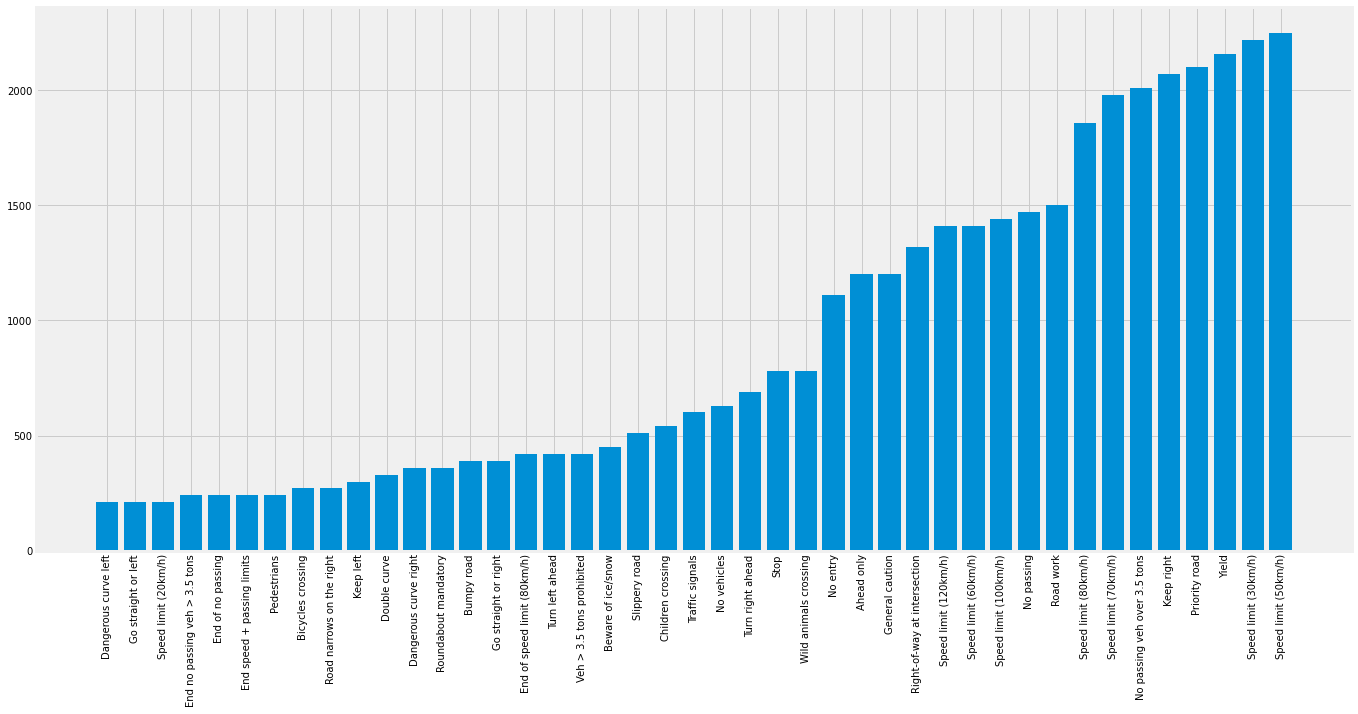

In [167]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

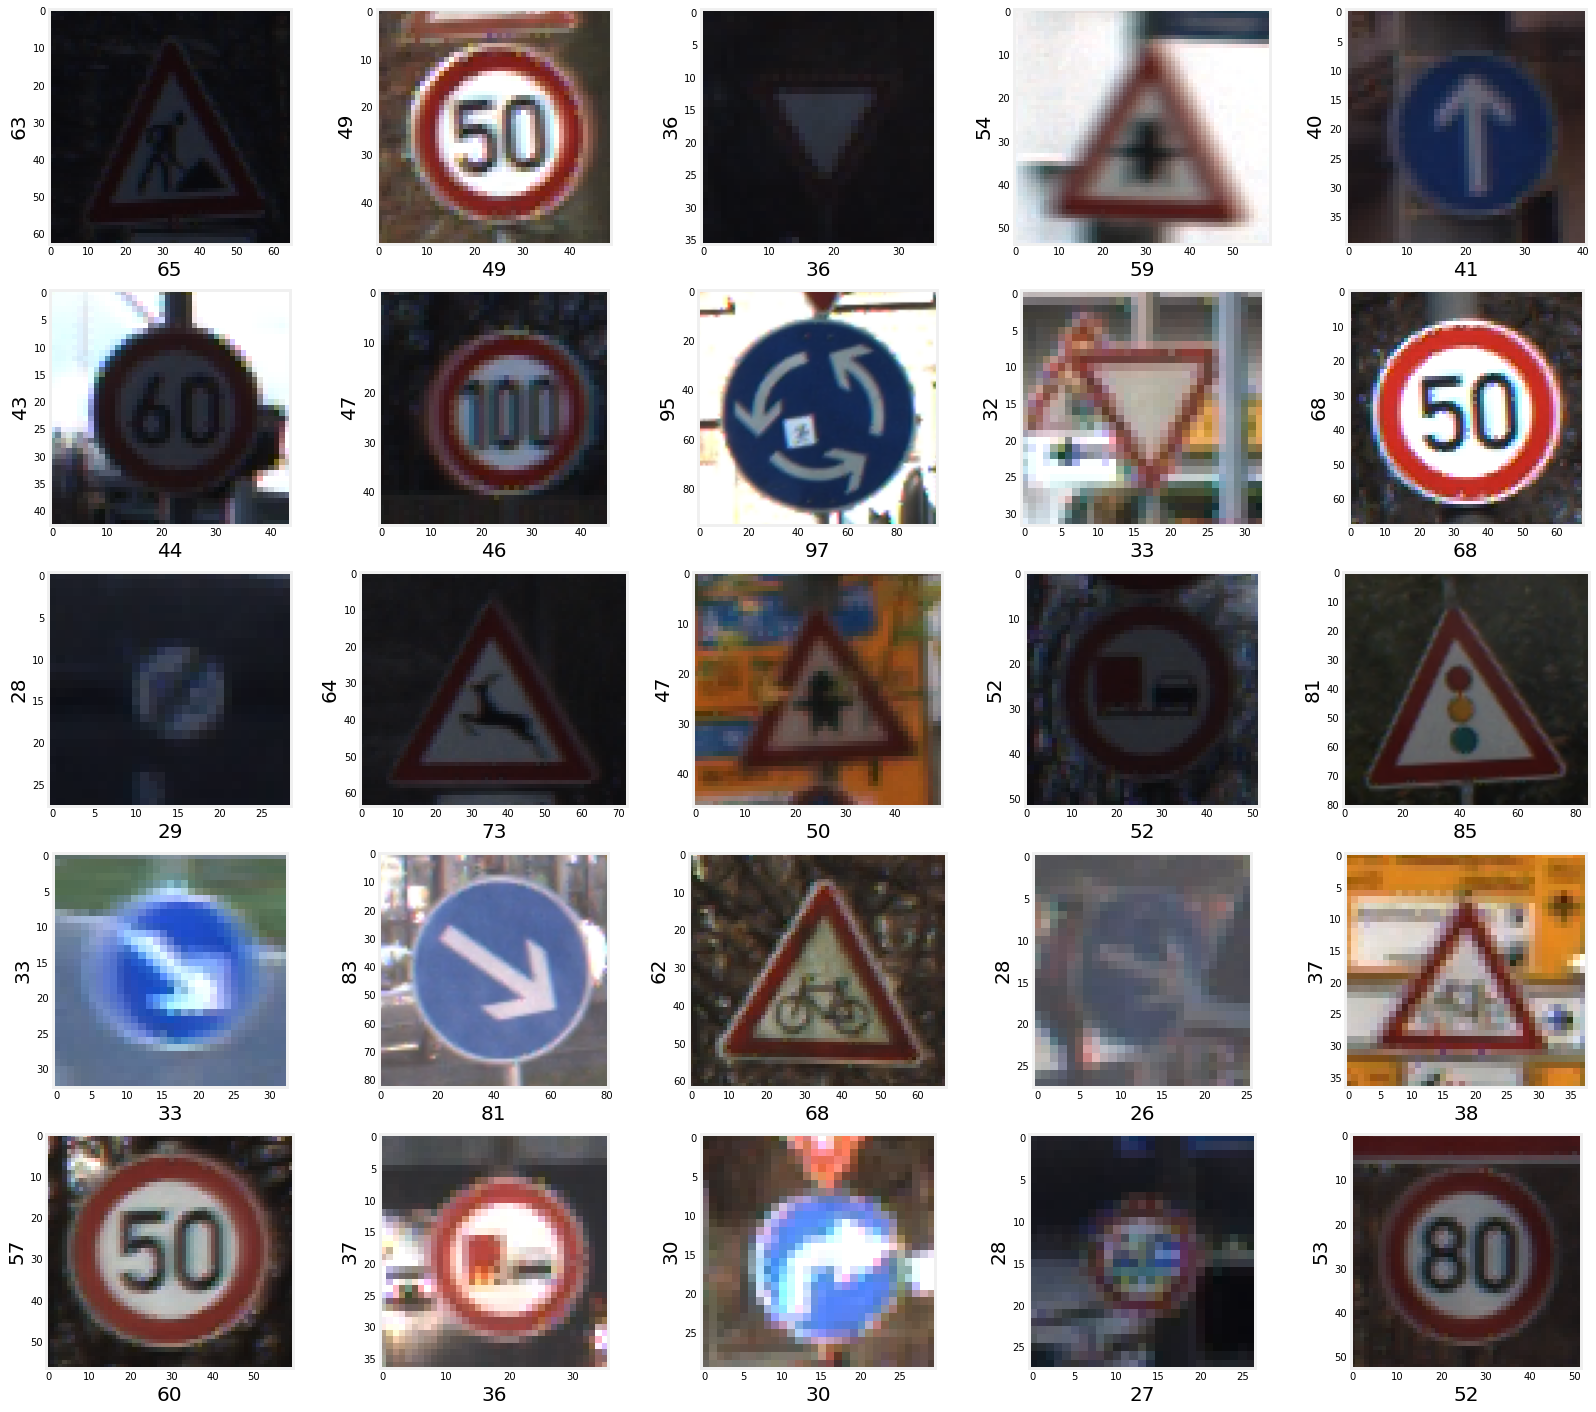

In [168]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [169]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data

In [170]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [171]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


# 1. CNN 

## One hot encoding the labels

In [172]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model

In [173]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [174]:
lr = 0.001
epochs = 30

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Augmenting the data and training the model

In [175]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 17s 20ms/step - loss: 1.0050 - accuracy: 0.7295 - val_loss: 0.0813 - val_accuracy: 0.9765
Epoch 2/30
858/858 [==============================] - 16s 19ms/step - loss: 0.1742 - accuracy: 0.9467 - val_loss: 0.0711 - val_accuracy: 0.9755
Epoch 3/30
858/858 [==============================] - 16s 19ms/step - loss: 0.1042 - accuracy: 0.9671 - val_loss: 0.0228 - val_accuracy: 0.9922
Epoch 4/30
858/858 [==============================] - 17s 19ms/step - loss: 0.0767 - accuracy: 0.9772 - val_loss: 0.0411 - val_accuracy: 0.9867
Epoch 5/30
858/858 [==============================] - 16s 19ms/step - loss: 0.0655 - accuracy: 0.9791 - val_loss: 0.0142 - val_accuracy: 0.9957
Epoch 6/30
858/858 [==============================] - 16s 19ms/step - loss: 0.0591 - accuracy: 0.9814 - val_loss: 0.0122 - val_accuracy: 0.9959
Epoch 7/30
858/858 [==============================] - 16s 19ms/step - loss: 0.0491 - accuracy: 0.9851 - val_loss: 0.0156 - val_accuracy:

## Evaluating the model

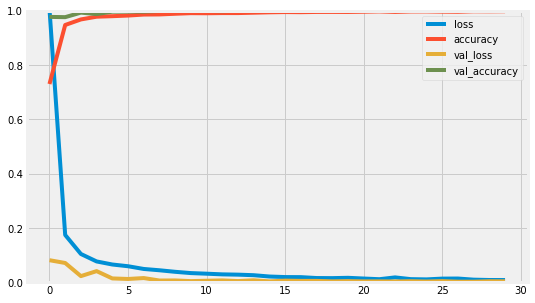

In [176]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions

In [177]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

In [178]:
X_test1 = X_test
X_test2 = X_test
X_test3 = X_test
X_test4 = X_test
X_test5 = X_test

In [179]:
pred = model.predict_classes(X_test1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  98.67775138558986


## Visualizing the confusion matrix

In [180]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

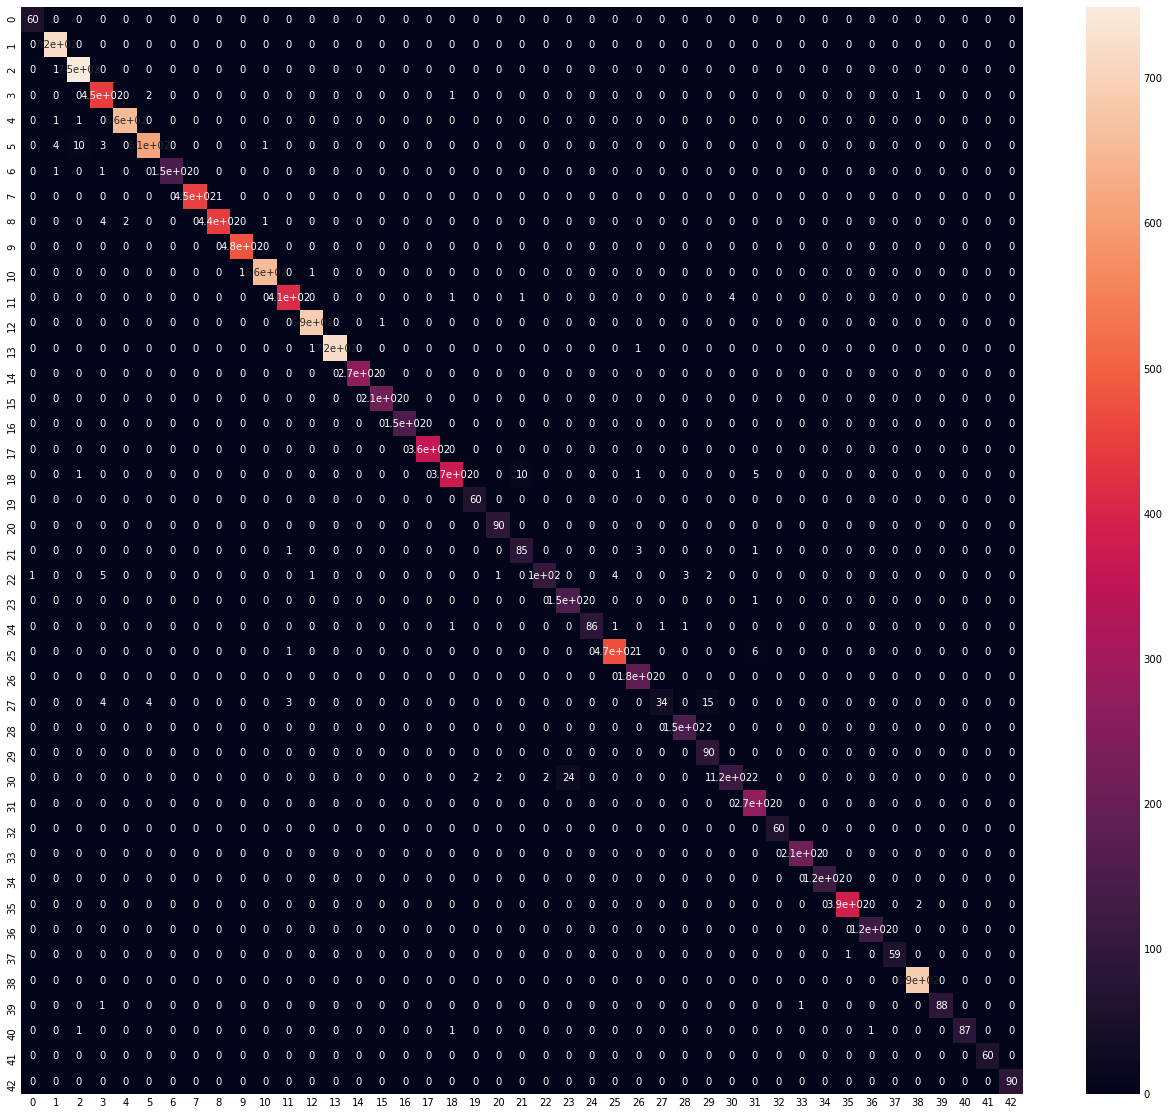

In [181]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [182]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.99      1.00      1.00       720
           2       0.98      1.00      0.99       750
           3       0.96      0.99      0.98       450
           4       1.00      1.00      1.00       660
           5       0.99      0.97      0.98       630
           6       1.00      0.99      0.99       150
           7       1.00      1.00      1.00       450
           8       1.00      0.98      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.99      0.99       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

In [183]:
model.save('cnn.h5')

# 2. FCNN

## Loading the dataset and preprossing for FCNN:

In [89]:
dir = '../input/gtsrb-german-traffic-sign'

In [90]:
def preprocess(image, out_side):
    height, width = image.shape[:2]
    scale = out_side / max(height, width)
    dx = (out_side - scale * width) / 2
    dy = (out_side - scale * height) / 2
    trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
    image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
    image = cv2.resize(image, (out_side, out_side))
    return image

def mixing(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])
    np.random.seed(43)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels

def load_train(path, out_side):
    images = []
    labels = []
    for folder in os.listdir(os.path.join(path, 'Train')):
        cur_path = os.path.join(path, 'Train', folder)
        for file_name in os.listdir(cur_path):
            image = cv2.imread(os.path.join(cur_path, file_name))
            images.append(preprocess(image, out_side))
            labels.append(int(folder))

    return mixing(images, labels)

def load_test(path, out_side):
    images = []
    labels = []
    with open(os.path.join(path, 'Test.csv'), 'r') as f:
        reader = csv.reader(f)
        for rows in reader:
            name = rows[7]
            if (name == 'Path'):
                continue
            image = cv2.imread(os.path.join(path, rows[7]))
            images.append(preprocess(image, out_side))
            labels.append(int(rows[6]))

    return mixing(images, labels)

In [92]:
start = time()

train_images, train_labels = load_train(dir + "/", 50)
test_images, test_labels = load_test(dir + "/", 50)
shape = train_images[0].shape
print(shape)

train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

train_labels = utils.to_categorical(train_labels, 43)
test_labels = utils.to_categorical(test_labels, 43)

print('Loading: ', time() - start)

(50, 50, 3)
Loading:  196.05087518692017


## Model:

In [93]:
classes = 43
batch = 256
epochs = 20
learning_rate = 0.001

def results(model):
  adam = Adam(lr=learning_rate)

  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  start = time()
  history = model.fit(train_images, train_labels, batch_size=batch, epochs=epochs, validation_split=0.2, shuffle = True, verbose=1)
  train_time = time() - start

  model.summary()

  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  start = time()
  test_loss, test_acc = model.evaluate(test_images, test_labels)
  test_time = time() - start
  print('\nTrain time: ', train_time)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)
  print('Test time: ', test_time)

Epoch 1/20
123/123 [==============================] - 1s 11ms/step - loss: 2.3674 - accuracy: 0.4100 - val_loss: 1.4915 - val_accuracy: 0.6432
Epoch 2/20
123/123 [==============================] - 1s 7ms/step - loss: 1.1402 - accuracy: 0.7314 - val_loss: 0.8593 - val_accuracy: 0.8170
Epoch 3/20
123/123 [==============================] - 1s 7ms/step - loss: 0.7124 - accuracy: 0.8441 - val_loss: 0.6074 - val_accuracy: 0.8683
Epoch 4/20
123/123 [==============================] - 1s 8ms/step - loss: 0.5185 - accuracy: 0.8900 - val_loss: 0.4824 - val_accuracy: 0.8926
Epoch 5/20
123/123 [==============================] - 1s 8ms/step - loss: 0.3974 - accuracy: 0.9198 - val_loss: 0.3867 - val_accuracy: 0.9199
Epoch 6/20
123/123 [==============================] - 1s 8ms/step - loss: 0.3340 - accuracy: 0.9306 - val_loss: 0.3414 - val_accuracy: 0.9207
Epoch 7/20
123/123 [==============================] - 1s 8ms/step - loss: 0.2754 - accuracy: 0.9456 - val_loss: 0.2921 - val_accuracy: 0.9374
Epoch

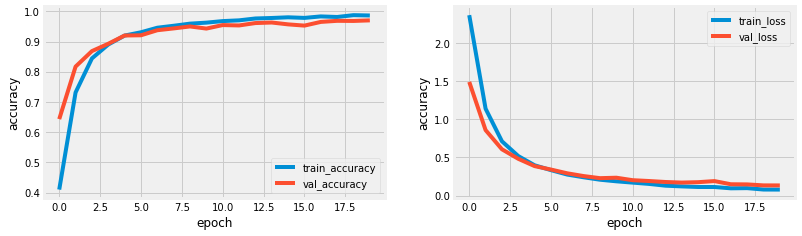

395/395 [==============================] - 1s 3ms/step - loss: 0.5546 - accuracy: 0.8543

Train time:  20.848028898239136
Test accuracy: 0.8543151021003723
Test loss: 0.5546271800994873
Test time:  1.3988871574401855


In [94]:
model = Sequential()
model.add(Flatten(input_shape=(50, 50, 3)))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(classes, activation='softmax'))

results(model)

In [123]:
model.save('fcnn.h5')

In [ ]:
pred = model.predict_classes(X_test)



In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((50, 50))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

In [ ]:
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  86.326207442597


### Confusion Matrix

In [ ]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

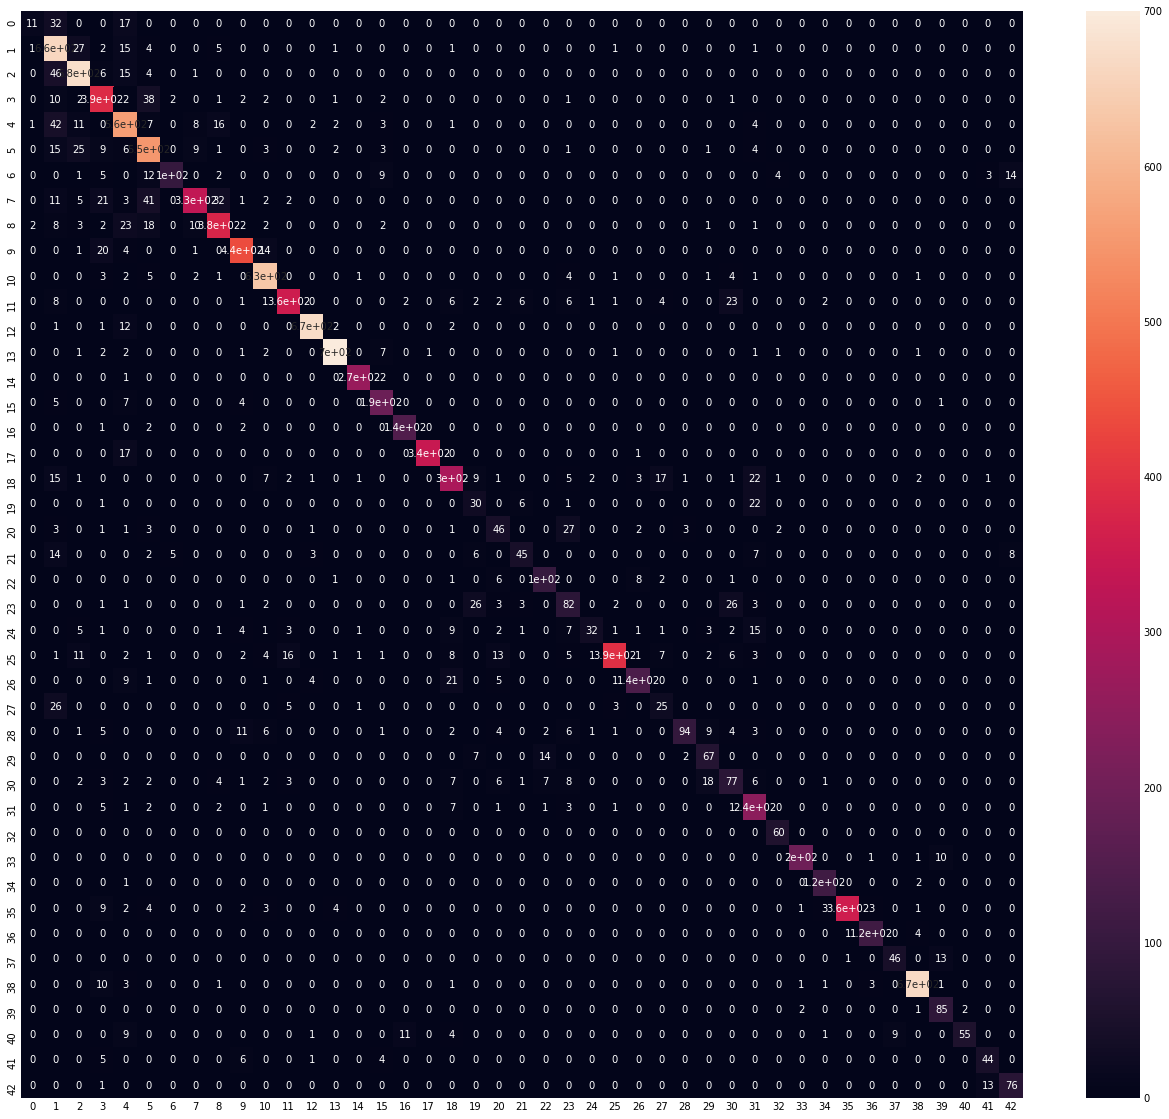

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

### Classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.73      0.18      0.29        60
           1       0.74      0.92      0.82       720
           2       0.88      0.90      0.89       750
           3       0.77      0.86      0.81       450
           4       0.78      0.85      0.82       660
           5       0.79      0.87      0.83       630
           6       0.93      0.67      0.78       150
           7       0.91      0.74      0.82       450
           8       0.85      0.84      0.84       450
           9       0.92      0.92      0.92       480
          10       0.92      0.96      0.94       660
          11       0.92      0.85      0.88       420
          12       0.98      0.97      0.98       690
          13       0.98      0.97      0.98       720
          14       0.98      0.99      0.99       270
          15       0.85      0.92      0.88       210
          16       0.92      0.97      0.94       150
          17       1.00    

# 3. VGG-19

## Loading and preprossing for VGG-19

In [95]:
dir = '../input/gtsrb-german-traffic-sign'

In [96]:
def preprocess(image, out_side):
    height, width = image.shape[:2]
    scale = out_side / max(height, width)
    dx = (out_side - scale * width) / 2
    dy = (out_side - scale * height) / 2
    trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
    image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
    image = cv2.resize(image, (out_side, out_side))
    return image

def mixing(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])
    np.random.seed(43)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels

def load_train(path, out_side):
    images = []
    labels = []
    for folder in os.listdir(os.path.join(path, 'Train')):
        cur_path = os.path.join(path, 'Train', folder)
        for file_name in os.listdir(cur_path):
            image = cv2.imread(os.path.join(cur_path, file_name))
            images.append(preprocess(image, out_side))
            labels.append(int(folder))

    return mixing(images, labels)

def load_test(path, out_side):
    images = []
    labels = []
    with open(os.path.join(path, 'Test.csv'), 'r') as f:
        reader = csv.reader(f)
        for rows in reader:
            name = rows[7]
            if (name == 'Path'):
                continue
            image = cv2.imread(os.path.join(path, rows[7]))
            images.append(preprocess(image, out_side))
            labels.append(int(rows[6]))

    return mixing(images, labels)

## Model

In [101]:
classes = 43
batch = 256
epochs = 3
learning_rate = 0.0001

def results(model2):
  adam = Adam(lr=learning_rate)

  model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  start = time()
  history = model2.fit(train_images, train_labels, batch_size=batch, epochs=epochs, validation_split=0.2, shuffle = True, verbose=1)
  train_time = time() - start

  model2.summary()

  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  start = time()
  test_loss, test_acc = model2.evaluate(test_images, test_labels)
  test_time = time() - start
  print('\nTrain time: ', train_time)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)
  print('Test time: ', test_time)

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/3
123/123 [==============================] - 32s 263ms/step - loss: 1.0540 - accuracy: 0.7696 - val_loss: 1.1791 - val_accuracy: 0.9505
Epoch 2/3
123/123 [==============================] - 31s 251ms/step - loss: 0.0617 - accuracy: 0.9940 - val_loss: 0.2821 - val_accuracy: 0.9867
Epoch 3/3
123/123 [==============================] - 31s 251ms/step - loss: 0.0277 - accuracy: 0.9966 - val_loss: 0.0521 - val_accuracy: 0.9964
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 1, 512)         2048      
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
___________________

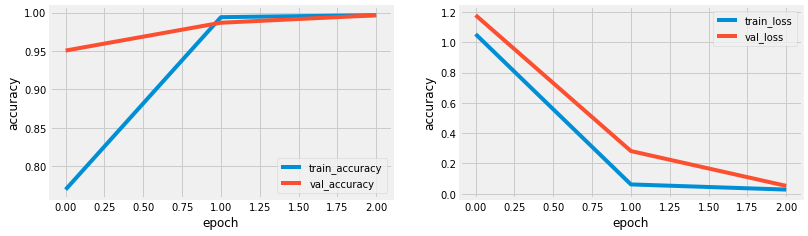

395/395 [==============================] - 6s 15ms/step - loss: 0.1538 - accuracy: 0.9695

Train time:  98.61029410362244
Test accuracy: 0.9695170521736145
Test loss: 0.1538439840078354
Test time:  6.647709846496582


In [102]:
model2 = Sequential()
model2.add(VGG19(weights='imagenet', include_top=False, input_shape=(50,50,3)))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dense(1024, activation='sigmoid'))
model2.add(Dense(43, activation='softmax'))

results(model2)

In [121]:
model2.save('vgg19.h5')

In [ ]:
pred = model2.predict_classes(X_test)

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((50, 50))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

In [ ]:
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  95.95407759303247


In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

In [ ]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

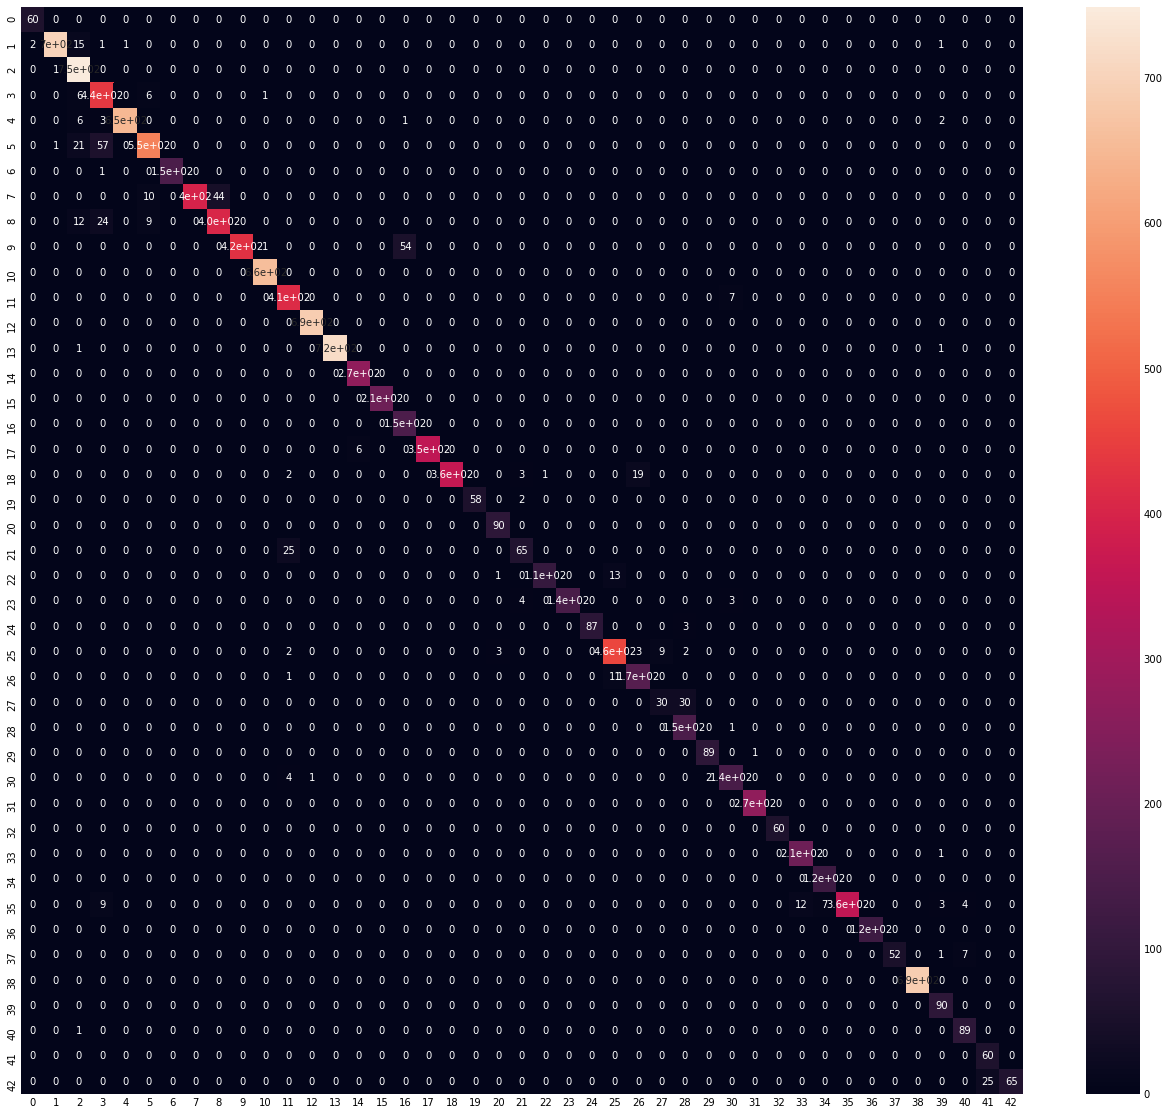

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.97      0.98       720
           2       0.92      1.00      0.96       750
           3       0.82      0.97      0.89       450
           4       1.00      0.98      0.99       660
           5       0.96      0.87      0.91       630
           6       1.00      0.99      1.00       150
           7       1.00      0.88      0.94       450
           8       0.90      0.90      0.90       450
           9       1.00      0.89      0.94       480
          10       1.00      1.00      1.00       660
          11       0.92      0.98      0.95       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       0.98      1.00      0.99       270
          15       1.00      1.00      1.00       210
          16       0.73      1.00      0.85       150
          17       1.00    

# 4. Xception

In [105]:
model3 = Sequential()
model3.add(Xception(include_top=False, weights=None, input_shape=(299, 299, 3), pooling='avg'))
model3.add(Dense(43))
model3.add(Softmax())
model3.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_14 (Dense)             (None, 43)                88107     
_________________________________________________________________
softmax (Softmax)            (None, 43)                0         
Total params: 20,949,587
Trainable params: 20,895,059
Non-trainable params: 54,528
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


20 Train/20/00020_00000_00020.png
Found 39209 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


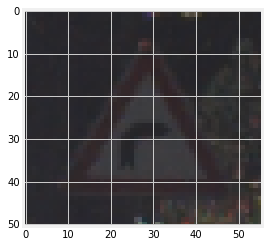

In [106]:
trainDataFrame = pd.read_csv('../input/gtsrb-german-traffic-sign/Train.csv')
testDataFrame = pd.read_csv('../input/gtsrb-german-traffic-sign/Test.csv')

trainDataFrame['ClassId'] = trainDataFrame['ClassId'].astype(str)
testDataFrame['ClassId'] = testDataFrame['ClassId'].astype(str)

for i in range(0, len(trainDataFrame['ClassId'])):
    if len(trainDataFrame['ClassId'][i]) == 1:
        trainDataFrame['ClassId'][i] = '0' + trainDataFrame['ClassId'][i]
for i in range(0, len(testDataFrame['ClassId'])):
    if len(testDataFrame['ClassId'][i]) == 1:
        testDataFrame['ClassId'][i] = '0' + testDataFrame['ClassId'][i]

print(trainDataFrame['ClassId'][20], trainDataFrame['Path'][20])
img = Image.open('../input/gtsrb-german-traffic-sign/' + trainDataFrame['Path'][20])
plt.imshow(img)

trainDataGen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2
)
testDataGen = image.ImageDataGenerator(
    rescale=1./255
)

trainDataGenerator = trainDataGen.flow_from_dataframe(
    dataframe=trainDataFrame,
    directory='../input/gtsrb-german-traffic-sign/',
    x_col='Path',
    y_col='ClassId',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)
testDataGenerator = testDataGen.flow_from_dataframe(
    dataframe=testDataFrame,
    directory='../input/gtsrb-german-traffic-sign/',
    x_col='Path',
    y_col='ClassId',
    target_size=(299, 299),
    batch_size=16,
    class_mode='categorical'
)

In [108]:
history = model3.fit(trainDataGenerator, epochs=2, verbose=1)

Epoch 1/2
1226/1226 [==============================] - 1367s 1s/step - loss: 0.7884 - accuracy: 0.7647
Epoch 2/2
1226/1226 [==============================] - 1357s 1s/step - loss: 0.0470 - accuracy: 0.9866


In [109]:
model3.evaluate(testDataGenerator, verbose=1)

790/790 [==============================] - 102s 129ms/step - loss: 0.7283 - accuracy: 0.8027


[0.7282864451408386, 0.8026919960975647]

#### Test accuracy: 0.8027
#### Train accuracy: 0.9866
#### test time: 102s
#### train time: 2724s
#### test loss: 0.7283
#### train loss: 0.0470

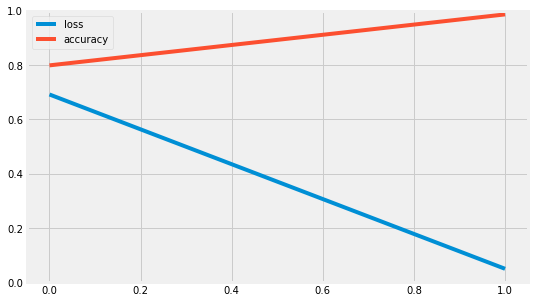

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()